# Notebook 02: GBM + GARCH Baselines

# Goal:

1. Build classical finance baselines before machine learning.

2. GBM models the underlying price dynamics.

3. GARCH models time-varying volatility (a major driver of option prices).

4. These baselines are later compared against Transformer / LSM / PPO.

# Outputs from this notebook:

1. Clean SPY log returns

2. Estimated GBM parameters (μ, σ)

3. GBM simulated price paths

4. Fitted GARCH model

5. Volatility forecasts that can become ML features

In [1]:
# Numerical and data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# GARCH modeling
from arch import arch_model

In [2]:
# ============================================================
# Load CLEAN daily datasets from Notebook 01
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

from pathlib import Path
DATA_DIR = Path("../data")

DAILIES = {
    "SPY":  DATA_DIR / "daily_clean_SPY.csv",
    "AAPL": DATA_DIR / "daily_clean_AAPL.csv",
}

daily = {}

for asset, path in DAILIES.items():
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

    # log return = log(P_t) - log(P_{t-1})
    # Why log returns?
    # - prices trend (non-stationary)
    # - returns are closer to stationary
    # - GARCH is defined on returns (variance dynamics), not price level
    df["log_return"] = np.log(df["Close"]).diff()
    df = df.dropna().reset_index(drop=True)

    daily[asset] = df

    print(f"[{asset}] rows={len(df):,} | Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")

[SPY] rows=3,521 | Date range: 2010-01-05 → 2023-12-29
[AAPL] rows=2,011 | Date range: 2016-01-05 → 2023-12-29


In [3]:
# Scale returns for numerical stability (per asset)
# GARCH is typically fit on returns ×100
scaled_returns = {
    asset: df["log_return"] * 100
    for asset, df in daily.items()
}

In [4]:
# ============================================================
# Fit GARCH(1,1) for EACH asset
# ============================================================

garch_results = {}

for asset, ret in scaled_returns.items():
    print(f"\nFitting GARCH(1,1) for {asset}...")

    model = arch_model(
        ret,
        vol="Garch",
        p=1,
        q=1,
        mean="Zero"
    )

    res = model.fit(disp="off")
    garch_results[asset] = res

    print(res.summary())


Fitting GARCH(1,1) for SPY...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4546.66
Distribution:                  Normal   AIC:                           9099.33
Method:            Maximum Likelihood   BIC:                           9117.83
                                        No. Observations:                 3521
Date:                Sun, Dec 28 2025   Df Residuals:                     3521
Time:                        05:21:11   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0352  7.40

In [5]:
# ============================================================
# Attach GARCH volatility back to each DAILY dataframe
# ============================================================

for asset in daily:
    daily[asset]["garch_vol"] = garch_results[asset].conditional_volatility / 100

# Quick sanity check
daily["SPY"].head()

,Date,Close,High,Low,Open,Volume,log_return,garch_vol
0,2010-01-05,85.253006,85.290522,84.667797,84.975410,111579900,0.002643,0.009672
1,2010-01-06,85.313065,85.523139,85.102990,85.170512,116074400,0.000704,0.008956
2,2010-01-07,85.673203,85.778240,84.915429,85.155515,131091100,0.004212,0.008270
3,2010-01-08,85.958313,85.995829,85.275571,85.448130,126402800,0.003322,0.007851
4,2010-01-11,86.078323,86.378426,85.710688,86.340916,106375700,0.001395,0.007423


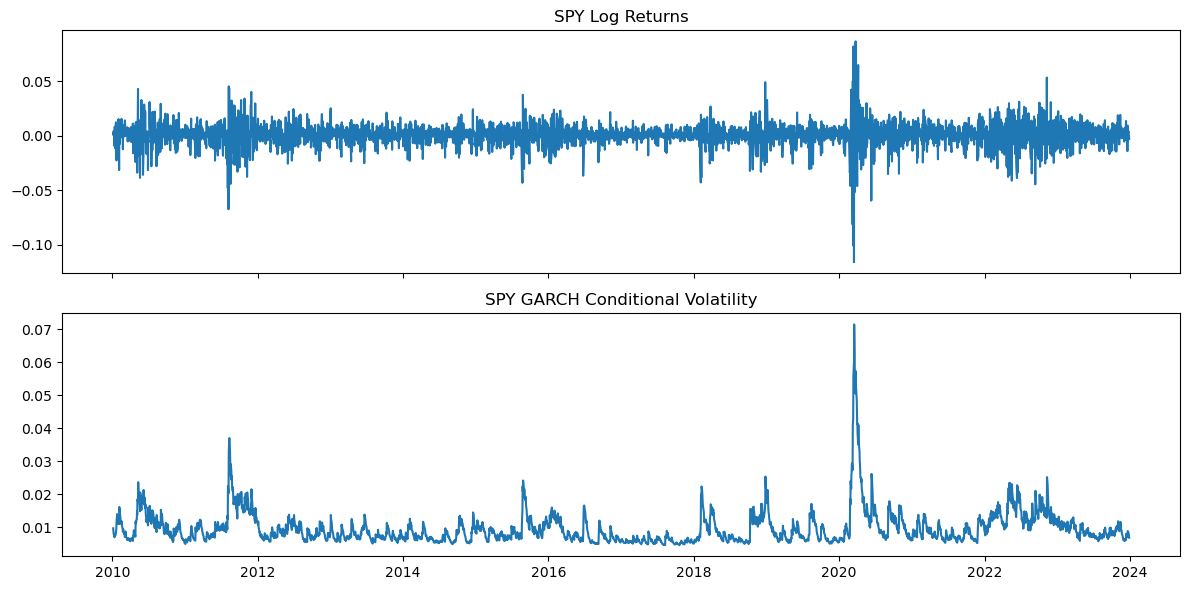

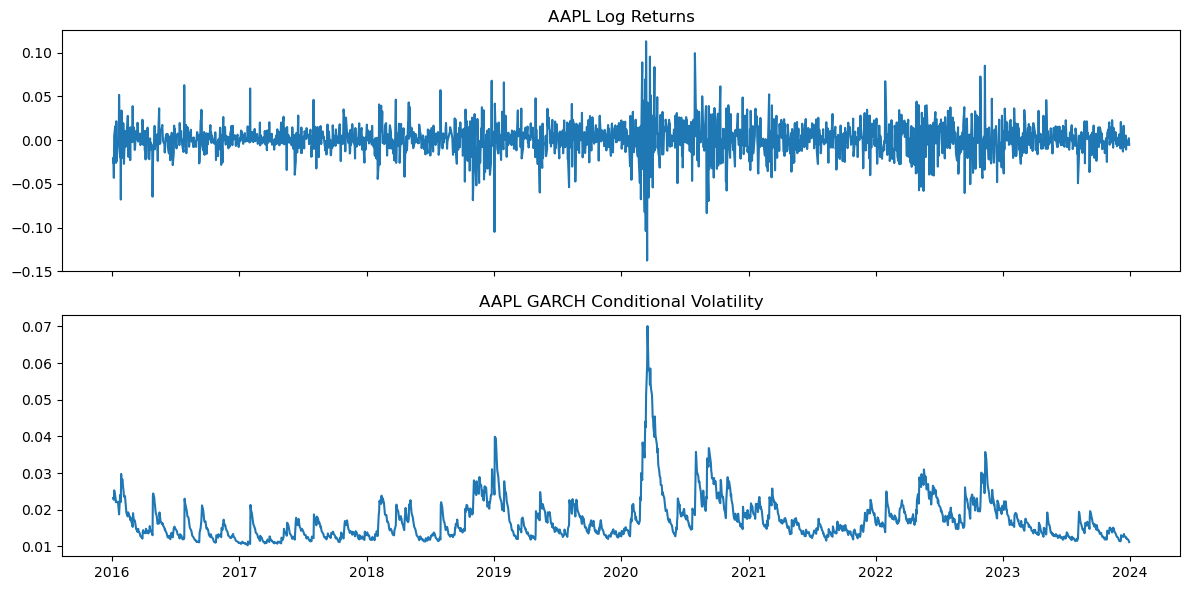

In [6]:
# ============================================================
# Plot returns and GARCH volatility (per asset)
# ============================================================

for asset, df in daily.items():
    fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

    ax[0].plot(df["Date"], df["log_return"])
    ax[0].set_title(f"{asset} Log Returns")

    ax[1].plot(df["Date"], df["garch_vol"])
    ax[1].set_title(f"{asset} GARCH Conditional Volatility")

    plt.tight_layout()
    plt.show()


[SPY] GBM baseline:
  Annualized drift (mu): 0.12142424963004543
  Annualized vol (sigma): 0.17379606396066116


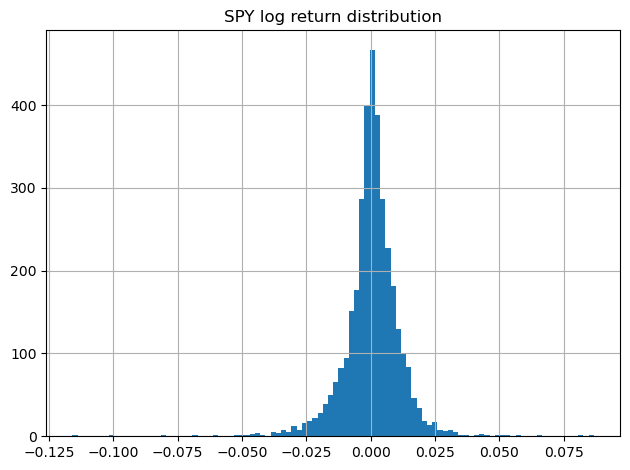


[AAPL] GBM baseline:
  Annualized drift (mu): 0.26103955946394
  Annualized vol (sigma): 0.29327477075855746


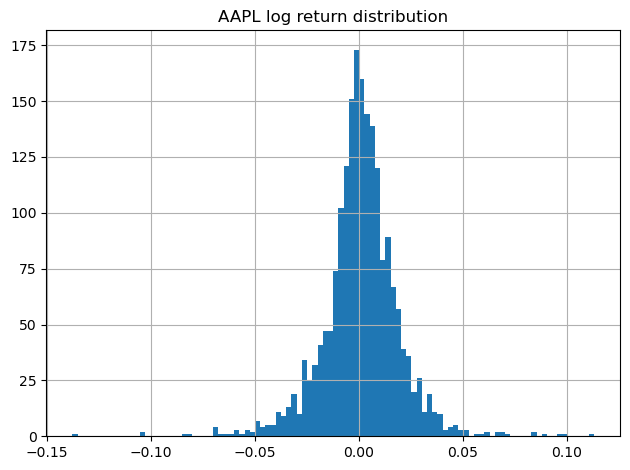

In [7]:
# ============================================================
# GBM baseline estimates (mu, sigma) for BOTH assets
# ============================================================

for asset, df in daily.items():
    mu = df["log_return"].mean() * 252
    sigma = df["log_return"].std() * np.sqrt(252)

    print(f"\n[{asset}] GBM baseline:")
    print("  Annualized drift (mu):", mu)
    print("  Annualized vol (sigma):", sigma)

    plt.figure()
    df["log_return"].hist(bins=100)
    plt.title(f"{asset} log return distribution")
    plt.tight_layout()
    plt.show()

In [8]:
# ============================================================
# Save DAILY datasets with GARCH volatility
# ============================================================

daily["SPY"].to_csv("../data/spy_with_garch.csv", index=False)
daily["AAPL"].to_csv("../data/aapl_with_garch.csv", index=False)

print("Saved:")
print("- ../data/spy_with_garch.csv")
print("- ../data/aapl_with_garch.csv")

Saved:
- ../data/spy_with_garch.csv
- ../data/aapl_with_garch.csv
